# ML Examinering
### Jacob "Kobbe" Eriksson

Importerar alla biblioteken som behövs för vår analys.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import warnings

Läser in data från csv-fil till en pandas DataFrame.

In [2]:
prices = pd.read_csv('commodity_prices.csv')

Tar en snabb titt på vår data för att se om det finns några uppenbara problem.

In [3]:
prices.head()

,Unnamed: 0,date,oil_brent,oil_dubai,coffee_arabica,coffee_robustas,tea_columbo,tea_kolkata,tea_mombasa,sugar_eu,sugar_us,sugar_world
0,1,1960-01-01,1.63,1.63,0.9409,0.696864,0.930301,1.121401,1.0374,0.122356,0.116845,0.0666
1,2,1960-02-01,1.63,1.63,0.9469,0.688707,0.930301,1.121401,1.0374,0.122356,0.119049,0.0679
2,3,1960-03-01,1.63,1.63,0.9281,0.688707,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683
3,4,1960-04-01,1.63,1.63,0.9303,0.684519,0.930301,1.121401,1.0374,0.122356,0.123459,0.0681
4,5,1960-05-01,1.63,1.63,0.9200,0.690692,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683


Tittar efter saknade värden i vår data och om det finns upprepade kolumner.

Vi ser att det inte finns några null värden i vår data, samt att det inte finns några upprepade kolumner.
Däremot så ser vi en unnamed kolumn som inte verkar ha någon funktion, så vi tar bort den för att städa datan lite.

In [4]:
prices.info()
prices.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       756 non-null    int64  
 1   date             756 non-null    object 
 2   oil_brent        756 non-null    float64
 3   oil_dubai        756 non-null    float64
 4   coffee_arabica   756 non-null    float64
 5   coffee_robustas  756 non-null    float64
 6   tea_columbo      756 non-null    float64
 7   tea_kolkata      756 non-null    float64
 8   tea_mombasa      756 non-null    float64
 9   sugar_eu         756 non-null    float64
 10  sugar_us         756 non-null    float64
 11  sugar_world      756 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 71.0+ KB


0

Droppar Unnamed kolumnen.

In [5]:
prices.drop(['Unnamed: 0'], axis=1, inplace=True)

Så med en liten snabb titt på vår data så försöker vi se om vi kan hitta några uppenbara samband mellan våra kolumner.
Vi börjar med att titta på priset av socker i EU under åren från 1960 till 2022.

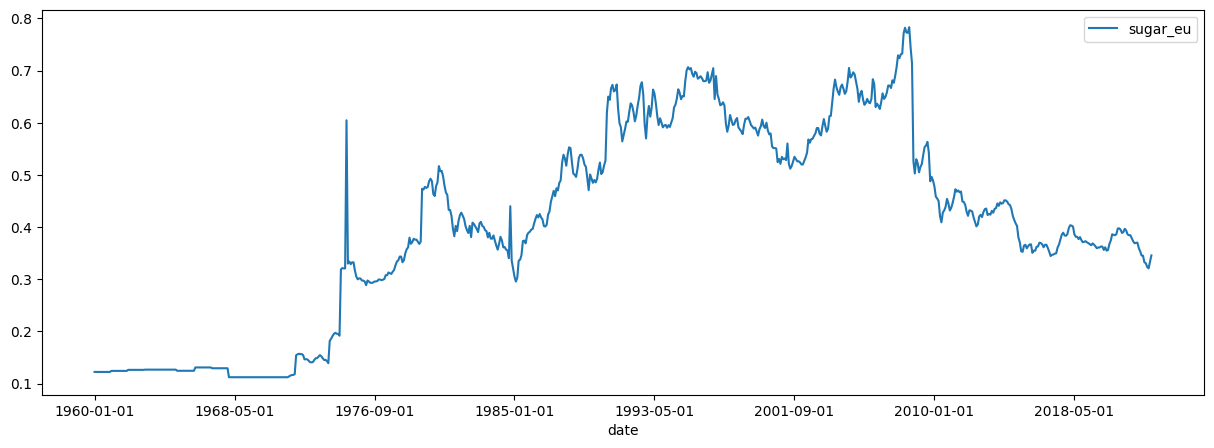

In [6]:
prices.plot(x='date', y='sugar_eu', figsize=(15, 5))
plt.show()

Vi kan se att priset började kraftigt stiga under 1970-talet med en kraftig prisökning under 1974-1975 och sedan en kraftig prisminskning under 1976-1977.
Sedan har priset varit relativt stabilt med vissa toppar och dalar. Intressant, men vi skulle kunna förenkla vår data på lite olika sätt.

Vi kan prova att ta fram "the rolling mean" av sockerpriset i eu genom åren, det bör ger oss en del av en tydligare bild.

Först skapar vi kopia av vår data som vi sedan kan modifiera utan att förstöra den ursprungliga datan.
Vi skapar också en ny kolumn: "avg_sugar_eur" där vi lägger in vår "rolling mean" av sockerpriset i eu.

Sedan skapar vi en graf för att visa upp vår nya average mean av priset per år.
Vi lägger även till några detaljer till grafen för att göra den tydligare såsom scatterpoints, grid, titel etc.

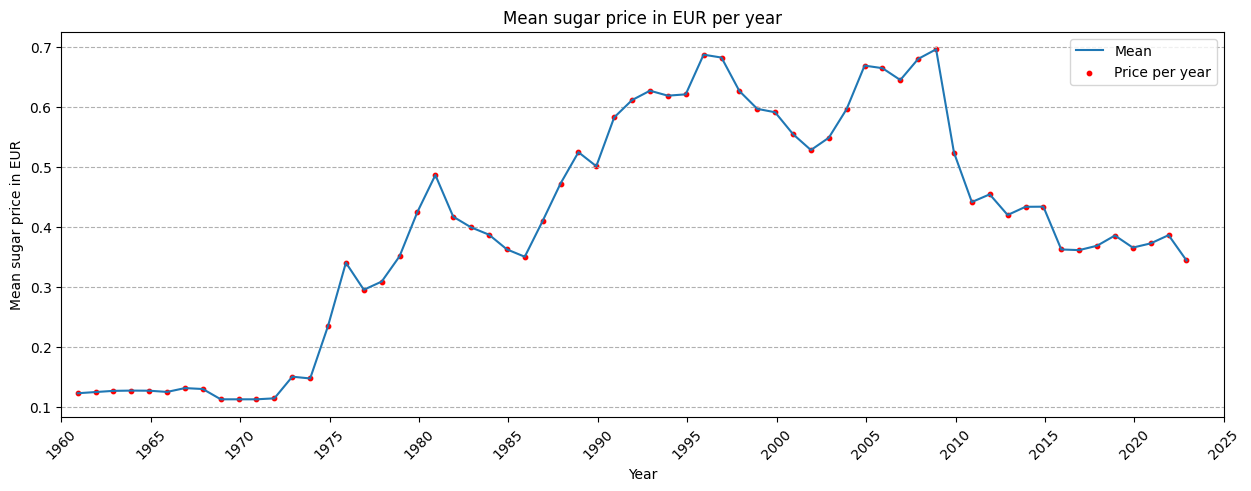

In [7]:
yearly_mean_prices = prices.copy()

yearly_mean_prices['date'] = pd.to_datetime(yearly_mean_prices['date'])

yearly_mean_prices['avg_sugar_eur'] = yearly_mean_prices.groupby(yearly_mean_prices['date'].dt.year)['sugar_eu'].transform(lambda x: x.rolling(12).mean())

yearly_mean_prices = yearly_mean_prices.dropna(subset=['avg_sugar_eur'])

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(yearly_mean_prices['date'], yearly_mean_prices['avg_sugar_eur'], label='Mean')
ax.scatter(yearly_mean_prices['date'], yearly_mean_prices['avg_sugar_eur'], color='red', label='Price per year', s=10)
ax.grid(True, which='both', axis='y', zorder=0, linestyle='dashed')
ax.set_xlabel('Year')
ax.set_ylabel('Mean sugar price in EUR')
ax.set_title('Mean sugar price in EUR per year')

years = mdates.YearLocator(5)
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.xticks(rotation=45)

start_year = pd.to_datetime('1960')
end_year = pd.to_datetime('2025')
ax.set_xlim(start_year, end_year)

ax.legend()

plt.show()

Vi kan även göra samma sak, fast för varje månad per år. Nu minskar vi dock spannet av de åren vi tittar på, då vi annars får en mycket plottrig graf. Vi kör från 2010 till 2022 istället, då det är de senaste åren som är förmodligen är mest intressanta.

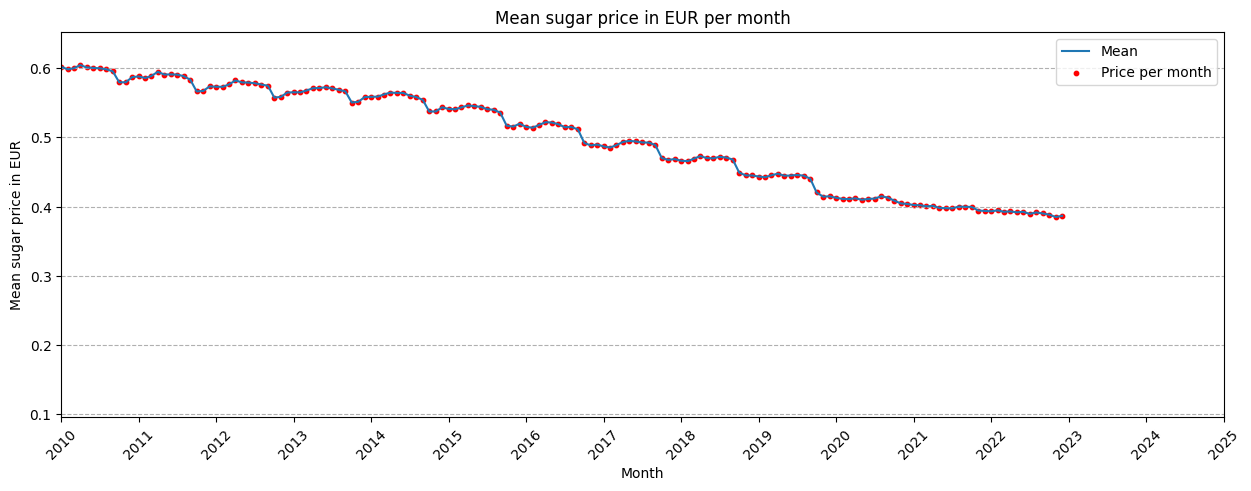

In [8]:
monthly_mean_prices = prices.copy()

monthly_mean_prices['date'] = pd.to_datetime(monthly_mean_prices['date'])

monthly_mean_prices['avg_sugar_eur'] = monthly_mean_prices.groupby(monthly_mean_prices['date'].dt.month)['sugar_eu'].transform(lambda x: x.rolling(12).mean())

monthly_mean_prices = monthly_mean_prices.dropna(subset=['avg_sugar_eur'])

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(monthly_mean_prices['date'], monthly_mean_prices['avg_sugar_eur'], label='Mean')
ax.scatter(monthly_mean_prices['date'], monthly_mean_prices['avg_sugar_eur'], color='red', label='Price per month', s=10)
ax.grid(True, which='both', axis='y', zorder=0, linestyle='dashed')
ax.set_xlabel('Month')
ax.set_ylabel('Mean sugar price in EUR')
ax.set_title('Mean sugar price in EUR per month')

months = mdates.YearLocator(1)
months_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.xticks(rotation=45)

start_year = pd.to_datetime('2010')
end_year = pd.to_datetime('2025')
ax.set_xlim(start_year, end_year)

ax.legend()

plt.show()

 Nedan ska vi försöka att skapa en ARIMA modell som förhoppningsvis kan göra en förutsägelse på framtida sockerpriset i EU.

 pmdarima har en funktion för att hitta den bästa upplägget för en ARIMA modell, så vi kan använda den för hitta vilka p, q och d värden som bör användas. I de flesta fallen så brukar man använda ett 1,1,1 upplägg för att hålla modellen så simpel som möjligt. Men om vi ville skulle vi kunna testa olika upplägg för att se om det skulle passa bättre eller ge en bättre förutsägelse.

 Vi kan ta det som en not för framtida tester jag skulle kunna ha haft i min notebook men valde att inte göra.

 ARIMA står för Auto-Regressive Integrated Mean Average och är en modell som försöker göra en prediction på en timeseries.
 AR blir p och MA blir q i ARIMA, med Integrated(I) som d, vilket är skillnaden mellan två datapunkter.
 Anledningen att vi inte kan använda oss av ARMA är för att vår data inte är "stationär" vilket enkelt sagt betyder att den inte har ett konstant medelvärde och varians över tid, samt att vår data har "seasonality", mönster som upprepar sig i vår data.

 ARIMA försöker alltså att från fram stationäritet genom att ta fram skillnaden ("differensen") mellan två datapunkter, i vårat fall, ett år och de föregående året (eg. 2020 + 2020-1) och få fram medelvärdet mellan dessa. Vi gör detta på alla våra datapunkter. Och förhoppningsvis så ska detta då passa in för en ARMA modell som då kan göra en förutsägelse ('prediction') för framtida datapunkter.

 I detta exempel så tar jag data som vi redan vet, för att sedan jämföra med vår ARIMA modell för att se hur bra den är på att förutsäga framtida datapunkter. Och som vi kan se nedan så verkar den ge oss ett ganska bra resultat.
 Det är dock ganska svårt att tyda data, med linjer nästintill liggandes på varandra. Vi behöver testa något annan graf-typ för att se om vi kan få en tydligare bild av vår prediction.

 Som en not för framtida utveckling av denna notebook så skulle jag önska att lägga till en bild för den matematiska formeln för ARIMA modellen som jag skulle kunna visa upp och gå igenom, punkt för punkt.
 En annan förbättring skulle vara att ta reda på om det finns snabbare utträkningar eller andra sätt att integrera ARIMA, då utträkningen tar en mycket lång tid.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2084.712, Time=0.40 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-3339.358, Time=6.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2632.546, Time=3.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2084.021, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-3192.048, Time=0.27 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-3421.803, Time=17.96 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=36.41 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.25 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-2091.237, Time=6.73 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-3435.503, Time=28.60 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-3349.192, Time=8.11 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=20.21 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.40 sec
 ARIMA(3,0,0)(2,1,0)[12] inter

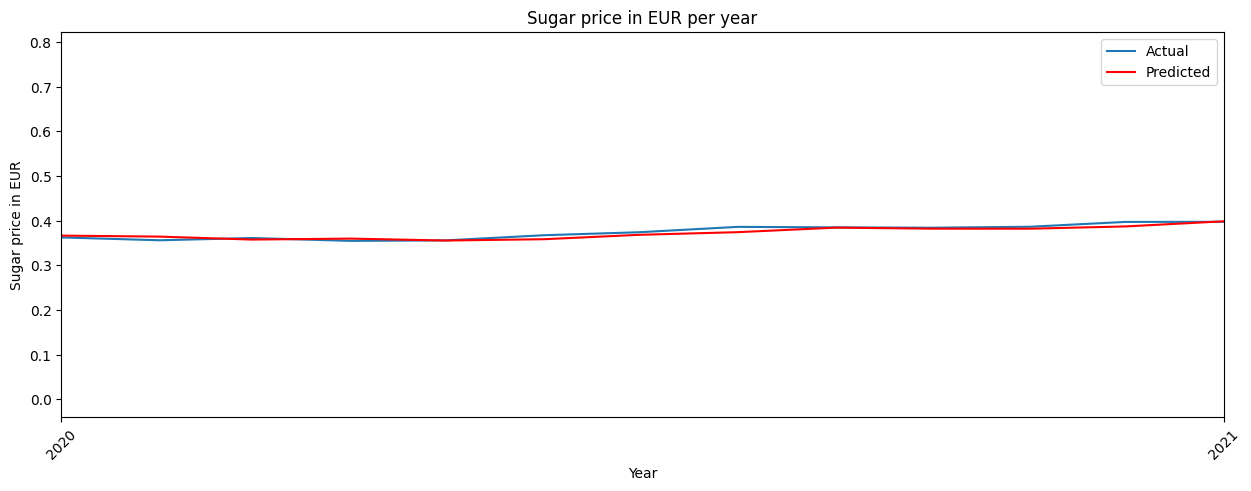

In [9]:
arima_prices = prices.copy()

arima_prices['date'] = pd.to_datetime(arima_prices['date'])

arima_prices.set_index('date', inplace=True)

model = pm.auto_arima(arima_prices['sugar_eu'], start_p=1, start_q=1,
                        test='adf', # Augmented Dickey-Fuller test
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

arima_pred = pd.DataFrame({'Actual': arima_prices['sugar_eu'],
                            'Predicted': model.predict_in_sample()},
                            index=arima_prices.index)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(arima_pred['Actual'], label='Actual')
ax.plot(arima_pred['Predicted'], color='red', label='Predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Sugar price in EUR')
ax.set_title('Sugar price in EUR per year')
ax.legend()

years = mdates.YearLocator(1)
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.xticks(rotation=45)

start_year = pd.to_datetime('2020')
end_year = pd.to_datetime('2021')
ax.set_xlim(start_year, end_year)

plt.show()


Här visar vi upp samma data som ovan, fast med en seasonal decompose för att tydligare se olika delar av vår data att jämföra.

Vi ser att alla delar, från trend, seasonal och residual verkar stämma relativt bra med vår prediction och den faktiska datan, men att vår prediction verkar vara ge oss ett något stabilare graf än den faktiska datan.

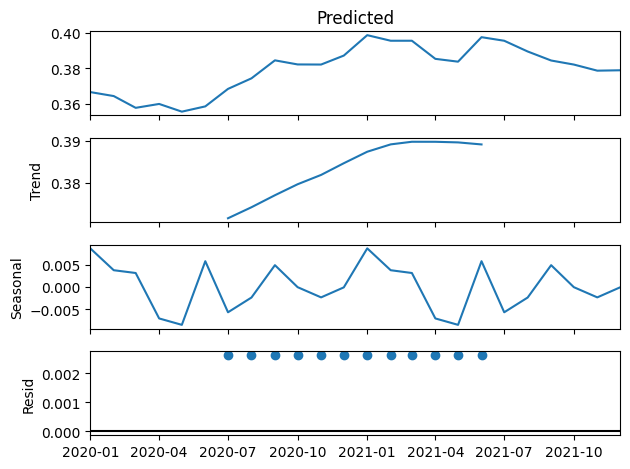

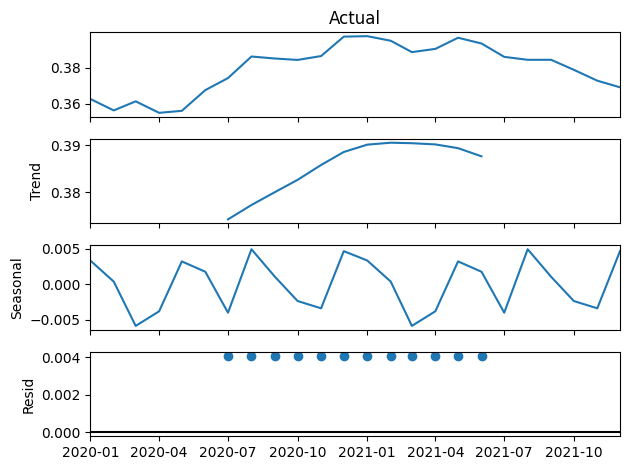

In [10]:
decompose_pred = seasonal_decompose(arima_pred['Predicted']['2020':'2021'], model='additive', period=12)
decompose_actual = seasonal_decompose(arima_pred['Actual']['2020':'2021'], model='additive', period=12)

decompose_pred.plot()
decompose_actual.plot()

plt.show()

Vi gör ett försök att göra en prediction av 2023 års sockerpris i EU. Och låter vår tidigare prediction/actual vara kvar för att jämföra med vår nya prediction.

Resultatet vi får ut ser relativt okej ut, fast man får fråga sig om priset kommer ligga så stabilt under året.
Det kan vara så att vår modell inte är tillräckligt bra för att göra en prediction, eller att den behöver göras under ett längre spann av tid för att få en mer intressant prediction.

En annan förbättring som skulle kunna göras är att göra en prediction för varje månad under året, istället för bara ett värde för hela året. Det kanske skulle ge oss en mer intressant bild av hur priset kommer att se ut under året.

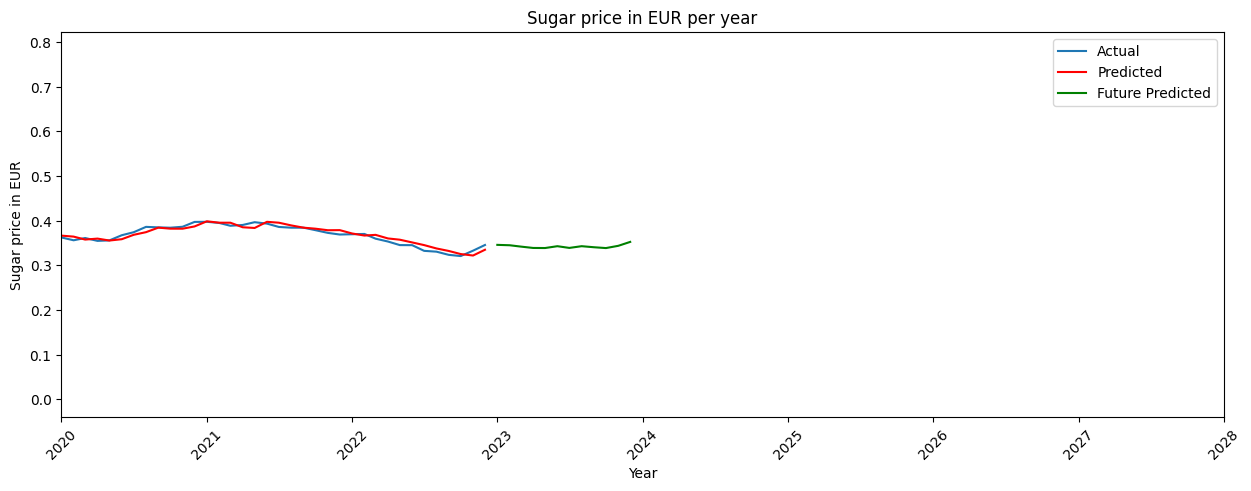

In [18]:
future_pred = pd.DataFrame({'Predicted': model.predict(n_periods=12)},
                            index=pd.date_range(start='2022-01-01', end='2025-01-01', freq='MS'))

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(arima_pred['Actual'], label='Actual')
ax.plot(arima_pred['Predicted'], color='red', label='Predicted')
ax.plot(future_pred['Predicted'], color='green', label='Future Predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Sugar price in EUR')
ax.set_title('Sugar price in EUR per year')
ax.legend()

years = mdates.YearLocator(1)
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

plt.xticks(rotation=45)

start_year = pd.to_datetime('2020')
end_year = pd.to_datetime('2025')
ax.set_xlim(start_year, end_year)

plt.show()

Nedan testar vi att visa upp vår prediction för sockerpriset i EU för 2023, med en graf som visar upp varje månad under året.

Då ser vi en tydligare uppgång framåt slutet av året, något som var svårare att se i vår tidigare graf, visserligen så är prisuppgången endast en fråga om decimaler men den visar åtminstone en trend som, om vi expanderade vår prediction ännu längre, kanske skulle kunna ge oss en mer intressant bild av framtida priser.

En möjlig framtida tillägg för denna prediction skulle vara att ta med den faktiska datan för 2023 och jämföra med vår prediction för att se hur korrekt (eller inte) den var. Problemet är att datasettet som jag använde inte har en tydlig förklaring till hur priserna har mätts eller hur man definerar "sugar_eu", alltså om det är ett genomsnitt av alla sockerpriser i EU eller om det är ett genomsnitt av alla sockerpriser i EU per land, eller något annat. Vilket gör att det skulle bli svårt att veta vad jag jämför med.

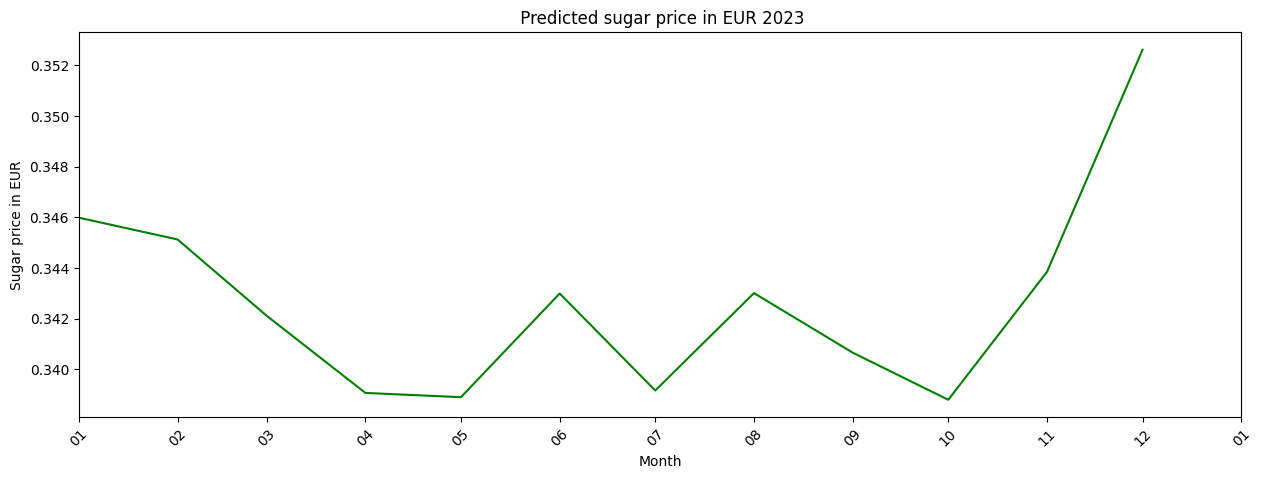

In [24]:
month_future_pred = pd.DataFrame({'Predicted': model.predict(n_periods=12)},
                            index=pd.date_range(start='2023-01-01', end='2024-01-01', freq='MS'))

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(month_future_pred['Predicted'], color='green', label='Future Predicted')
ax.set_xlabel('Month')
ax.set_ylabel('Sugar price in EUR')
ax.set_title(' Predicted sugar price in EUR 2023')

months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

plt.xticks(rotation=45)

start_year = pd.to_datetime('2023')
end_year = pd.to_datetime('2024')
ax.set_xlim(start_year, end_year)

plt.show()

Som vi kan se så finns det många olika ställen på datasetet där vi kan analysera och jämföra för att få fram olika intressanta detaljer.
Vi hade exempelvis kunnat göra en ARIMA modell för sockerpriset i US och sedan jämföra med sockerpriset i EU för att so hur de skiljer sig åt.
Vi hade kunna ställa upp vår framtida prediction av både sockerpriset i EU och US för att se hur de skiljer sig åt, hur ser trenden ut, är de mycket olika eller är de lika? och om de är lika, kan vi lista ut varför, eller visar det på att modellen har fel?

Det hade även varit intressant att att testa andra "commodities" som kaffe och te, och att använda olika visualseringsverktyg för att ge lite variation för data samt att kanske hitta några andra intressanta samband.